## Context
PROBA-V was developed as both a follow-up to the 15-year SPOT-VEGETATION mission, as well as a preparation for the upcoming ESA Sentinel-3 land and ocean observation satellite mission. The SPOT-VEGETATION mission provided essential information on e.g. crop yields, droughts, and deforestation to a broad user community. VITO is the prime investigator and data service provider of PROBA-V for the user community including product quality control.
Since October 16th 2013 PROBA-V emits amonst other things images of the world on a daily basis and organized in 10°x10° tiles.


##  Objective of this notebook
The aim here is to create a visualization tool to monitor these tiles (downloaded by the download center), i.e. check if tiles are missing, and in this case which tiles are missing. 
We aim to create a 10°x10° grid of the world map and mark down tiles that have been correctly received (in green) as well as flag out missing tiles (in red).

## Convention
- Because PROBA-V does not observe the poles, PROBA-V typically creates a 36 x 14 tiles grid as depicted in the following picture.
- To save energy PROBA-V does not either observe oceans so ocean tiles should not be flagged as missing
- We'll use a reference list of tiles 
- and a list of actual tiles that have been received

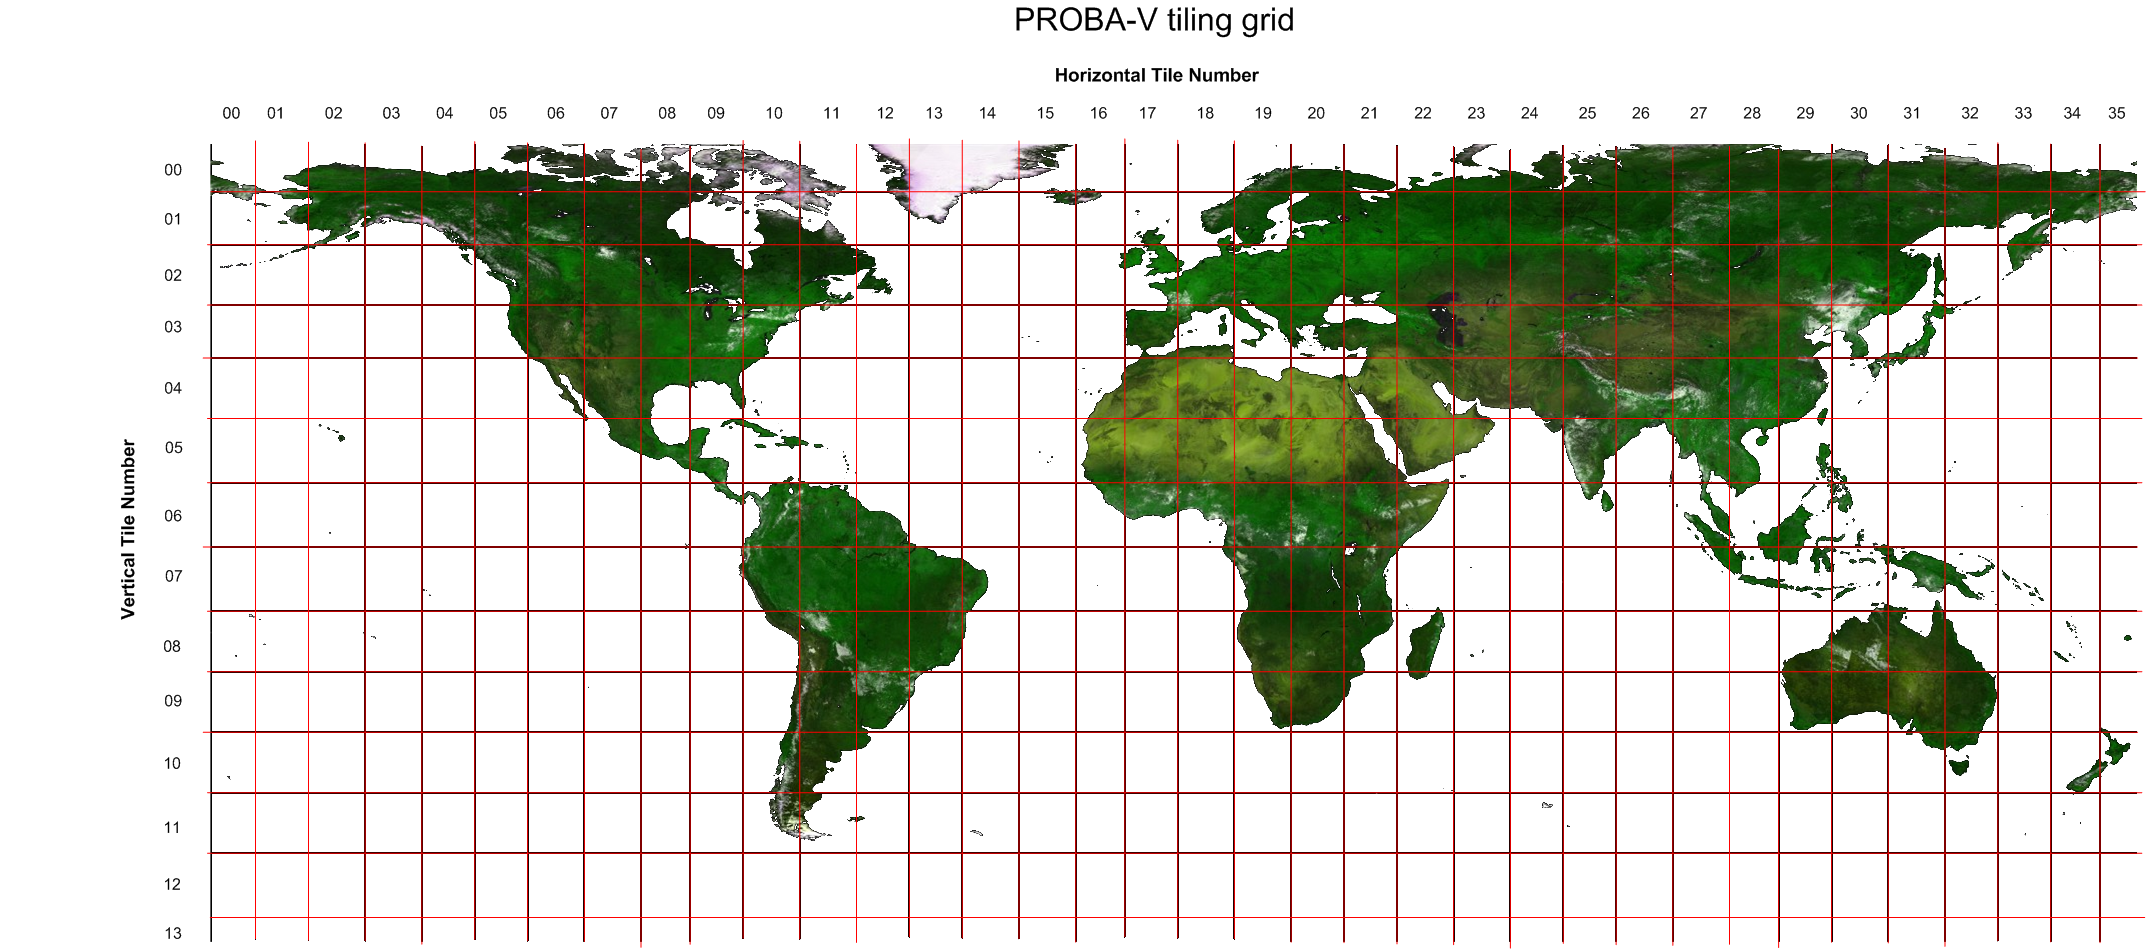

In [48]:
from IPython.display import Image
Image(filename='tileOverview.png')

In [49]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import data, color, io, img_as_float, img_as_int

(246, 472)
(180, 432)


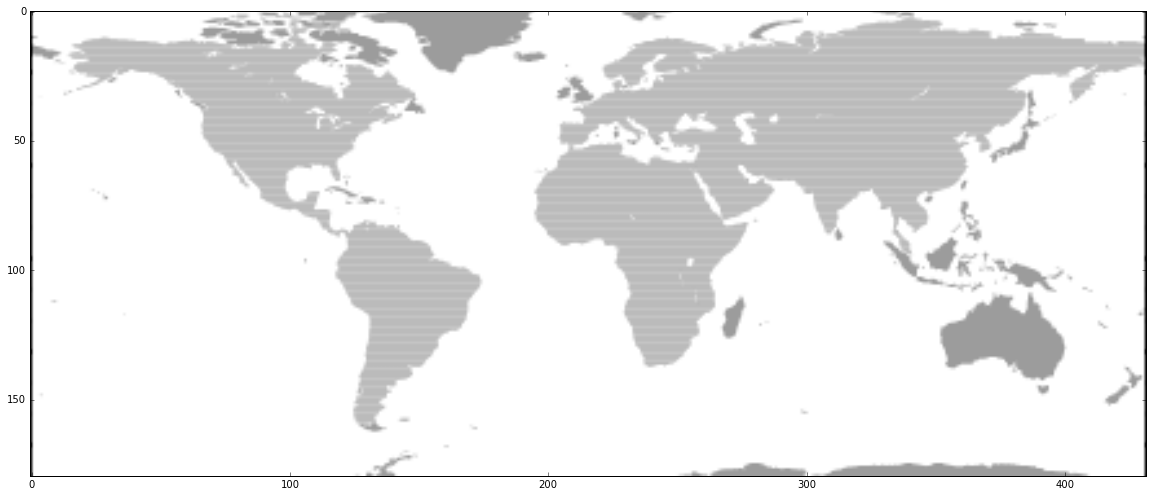

In [50]:
# Load background image 
im = mpimg.imread('map1.png')
print im.shape
# Crop input image to be consistent with PROBA-V overview
# im = im[33:290, 48:688]
im = im[20:200, 32:464]
print im.shape

# Show image
f, ax = plt.subplots(1, 1, figsize=(20, 10))
imgplot = plt.imshow(im, cmap=plt.get_cmap('gray'))

In [51]:
##################################################################################
# @brief Compute the coordinates (in pixels) within the map of tile (x,y)
# @param x            (int)    x-index of tile
# @param y            (int)    y-index of tile
# @param nbX          (int)    number of tiles along the x-axis within the map
# @param nbY          (int)    number of tiles along the y-axis within the map
# @param mapWidth     (int)    map width (in pixels)
# @param mapHeight    (int)    map height (in pixels)
# @return coordinates  [xleft, xright, ytop, ybottom] of tile 
def getMapCoordinates(x, y, nbX, nbY, mapWidth, mapHeight):
    # Compute tile width and height
    tWidth = float(mapWidth)/nbX
    tHeight = float(mapHeight)/nbY
    xLeft = x * tWidth
    xRight = xLeft + tWidth
    yTop = y * tHeight
    yBottom = yTop + tHeight
    return [int(xLeft), int(xRight), int(yTop), int(yBottom)]

In [52]:
# The PROBA-V map is divided in a 36 x 14 grid.
nbX = 36 # Nb horizontal tiles
nbY = 14 # Nb vertical tiles
mapHeight, mapWidth = im.shape
# Quick test
[x1, x2, y1, y2] = getMapCoordinates(0, 0, nbX, nbY, mapWidth, mapHeight)
print '{0}:{1} , {2}:{3}'.format(x1, x2, y1, y2)

0:12 , 0:12


In [53]:
##################################################################################
# @brief Extract the x and y indices of tile formatted as X[0-9][0-9]Y[0-9][0-9]
# @param tile       (string)    tile name
# @return x and y indices
def extractTileIndices(tile):
    # Tile format is XaaYbb
    return [int(tile[1:3]), int(tile[4:6])]
    

In [69]:
############################################################################################
# @brief Update colour mask for tile list
# @param colorMask    (array of float)    mask used to colour tiles
# @param mapWidth     (int)               map width (in pixels)
# @param mapHeight    (int)               map height (in pixels)
# @param tileLst      (list of string)    list of tile filenames
# @param nbX          (int)               number of tiles along the x-axis within the map
# @param nbY          (int)               number of tiles along the y-axis within the map
# @param colourRGB    (list of int)       colour as a list of R, G and B values in [0,1]
def updateColorMask(colorMask, mapHeight, mapWidth, tileLst, nbX, nbY, colourRGB):
    rows, cols, depth = colorMask.shape
    for tile in tileLst:
        # Extract tile indices in map
        [i, j] = extractTileIndices(tile)
        # Derive tile x,y pixel ranges within the map
        [x1, x2, y1, y2] = getMapCoordinates(i, j, nbX, nbY, cols, rows)
        # Colour tiles
        colorMask[y1:y2, x1:x2] = colourRGB 
        # Colour tile border
        colourBlue = [0.25, 0.25, 0.25]
        colorMask[y1:y2, x1:x1+1] = colourBlue
        colorMask[y1:y2, x2-1:x2] = colourBlue
        colorMask[y1:y1+1, x1:x2] = colourBlue
        colorMask[y2-1:y2, x1:x2] = colourBlue

In [70]:
##################################################################################################
# @brief Detect missing tiles by comparing the actual list of received tiles to a reference list 
# @param currentTileLst      (list of string)    list of tile received
# @param refTileLst          (list of string)    reference list of tiles
# @return list of missing tiles
def detectMissingTiles(currentTileLst, refTileLst):
    #return [tile for tile in refTileLst if tile not in currentTileLst]
    return list(set(refTileLst) - set(currentTileLst)) 

In [71]:
##################################################################################################
# @brief Extract tile name from tile path
# @param filepath      (string)    file containing a list of tiles
# @return sorted list of tile names (format X[0-9][0-9]Y[0-9][0-9])
import re
def extractTilesFromFile(filepath):
    tileLst = []
    pattern = 'X[0-9][0-9]Y[0-9][0-9]'
    with open(filepath) as file:
        for line in file.readlines():
            tileLst.append(re.search(pattern, line).group(0))
    return sorted(tileLst)

In [72]:
# In this example we'll use a list of reference tiles, and a dummy list of tiles 
# from which we have removed 3 tiles: X12Y06, X11Y07, X10Y08
refTileLst = extractTilesFromFile('tiles_ref.txt')
tileLst = extractTilesFromFile('tiles_received.txt')

## Create grid of present (green) and missing (red) tiles with worls map as background

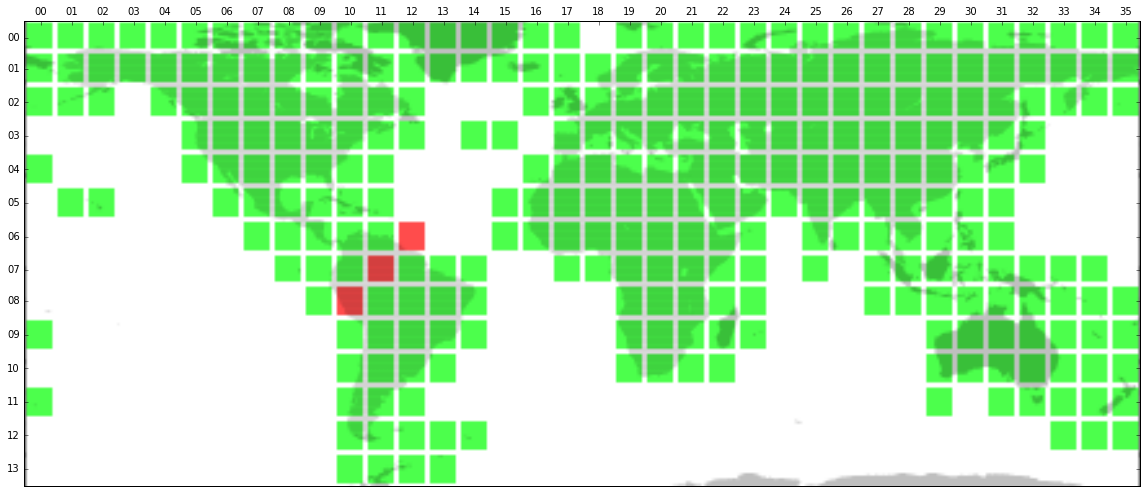

In [73]:
alpha = 0.7 # Saturation value
colourOK = [0, 1, 0] # green RGB colour
colourMissing = [1, 0, 0] # red RGB colour

img = img_as_float(im)
rows, cols = img.shape

# Construct a colour image to superimpose
colorMask = np.zeros((rows, cols, 3), dtype=np.float)

# Display tiles that are detected in green
updateColorMask(colorMask, rows, cols, tileLst, nbX, nbY, colourOK)
# Display tiles that are missing in red
missingTileLst = detectMissingTiles(tileLst, refTileLst)
updateColorMask(colorMask, rows, cols, missingTileLst, nbX, nbY, colourMissing)

# Construct RGB version of grey-level image
imgColor = np.dstack((img, img, img))

# Convert the input image and color mask to Hue Saturation Value (HSV)
imgHsv = color.rgb2hsv(imgColor)
colorMaskHsv = color.rgb2hsv(colorMask)

# Replace the hue and saturation of the original image with the one of the color mask
imgHsv[..., 0] = colorMaskHsv[..., 0]
imgHsv[..., 1] = colorMaskHsv[..., 1] * alpha
imgMasked = color.hsv2rgb(imgHsv)

# x and y labels
xlabel = [str(ii).zfill(2) for ii in  xrange(nbX)] # 00 -> 35
ylabel = [str(jj).zfill(2) for jj in  xrange(nbY)] # 00 -> 13
x = [ii * cols/nbX + cols/(2 *nbX) for ii in xrange(nbX)] # label positions on x-axis (centered within the 'bin')
y = [jj * rows/nbY + rows/(2 *nbY) for jj in xrange(nbY)] # label positions on y-axis (centered within the 'bin')

# Show map + tiles
f, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.imshow(imgMasked)
ax.xaxis.set_ticks_position('top') # set ylabel on top
plt.xticks(x, xlabel)
plt.yticks(y, ylabel)
plt.show()
